In [2]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys, os
import json
import torch.nn as nn  
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import prettytable
import time
sys.setrecursionlimit(15000)
from thop.profile import profile
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import seaborn as sns
from pathlib import Path

# Add FixCaps path to sys.path
sys.path.append(str(os.path.abspath(os.path.join(os.getcwd(), "..",)) + '/FixCaps' +'/Module'))

root_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
fixcaps_path = os.path.join(root_dir, "FixCaps")
sys.path.append(fixcaps_path)

from HAM10000.model import FixCapsNet
from HAM10000.utils import ImageShow, draw_size_acc, one_hot
from HAM10000.utils import confusion_matrix, metrics_scores, pff

In [3]:
# Settings.
if torch.cuda.is_available():
    device = torch.device('cuda')  # Use CUDA
    print("CUDA Available: ", True)
    print("CUDA Device Count: ", torch.cuda.device_count())
    print("CUDA Device Name: ", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')  # Fall back to CPU
    print("CUDA Available: ", False)
    print("Using CPU instead")

img_title = "HAM10000"
best_acc = 0.
eval_acc = 0.
best_train = 0.
dict_batch = {}
dict_imgSize = {}

#defined 
try:
    print(len(train_acc_list))
except NameError:
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []
    test_auc_list = []
    val_loss_list = []
    val_acc_list = []
#activate ImageShow
show = ImageShow(train_loss_list = train_loss_list,
                 train_acc_list = train_acc_list,
                test_loss_list = test_loss_list,
                test_acc_list = test_acc_list,
                test_auc_list = test_auc_list,
                val_loss_list = val_loss_list,
                val_acc_list = val_acc_list,
                )

CUDA Available:  False
Using CPU instead


In [4]:
train_dir = os.path.join(root_dir, "train")
val_dir = os.path.join(root_dir, "val")
test_dir = os.path.join(root_dir, "test")
print(train_dir)
print(val_dir)
print(test_dir)

d:\Code\NCKH2025\CNN\data\train
d:\Code\NCKH2025\CNN\data\val
d:\Code\NCKH2025\CNN\data\test


In [5]:
def get_data(trans_test='312'):
    global test_dataset,train_loader,val_loader,test_loader
    global train_num,val_num,test_num,n_classes,cla_dict
    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop((299, 299)),
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "val": transforms.Compose([transforms.Resize((302,302)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ]),
        "test": transforms.Compose([transforms.Resize((trans_test,trans_test)),
                                   transforms.CenterCrop((299, 299)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ])
        }

    data_root = os.path.abspath(os.path.join(os.getcwd(),".."))  # get data root path
    image_path = os.path.join(data_root, "data")#
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)

    train_dataset = datasets.ImageFolder(root=os.path.join(image_path,train_doc),#
                                         transform=data_transform["train"])
    val_dataset = datasets.ImageFolder(root=os.path.join(image_path,val_doc),
                                            transform=data_transform["val"])
    test_dataset = datasets.ImageFolder(root=os.path.join(image_path,test_doc),
                                            transform=data_transform["test"])

    train_num = len(train_dataset)
    val_num = len(val_dataset)
    test_num = len(test_dataset)
    
    data_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in data_list.items())
    n_classes  = len(data_list)
    print(f'Using {n_classes } classes.')
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open(f'{img_title}.json', 'w') as json_file:#class_indices
        json_file.write(json_str)
        
    pin_memory = True
    train_loader = DataLoader(train_dataset,batch_size=BatchSize,
                                               pin_memory=pin_memory,
                                               shuffle=True,num_workers=nw)
    val_loader = DataLoader(val_dataset,batch_size=V_size,
                                               pin_memory=pin_memory,
                                               shuffle=False,num_workers=nw)
    test_loader = DataLoader(test_dataset,batch_size=T_size,
                                              pin_memory=pin_memory,
                                              shuffle=False,num_workers=nw)

    print("using {} images for training, {} images for validation, {} images for testing.".format(train_num,
                                                                                                  val_num,
                                                                                                  test_num))

In [6]:
BatchSize = 168
V_size = 40 
T_size = 32 
train_doc = "train"
val_doc = "val"
test_doc = "test"

nw = min([os.cpu_count(), BatchSize if BatchSize > 1 else 0, 6]) 
print(f'Using {nw} dataloader workers every process.')
get_data()

Using 6 dataloader workers every process.
Using 7 classes.
using 8010 images for training, 2005 images for validation, 1511 images for testing.


In [7]:
import os

def count_files_in_subfolders(root_dir):
    counts = {}
    for subset in ['train', 'val', 'test']:
        subset_path = os.path.join(root_dir, subset)
        file_count = 0
        if os.path.exists(subset_path):
            # Count files in the directory and its subdirectories
            for dirpath, dirnames, filenames in os.walk(subset_path):
                file_count += len(filenames)
            counts[subset] = file_count
    return counts

file_counts = count_files_in_subfolders(root_dir)

# Print the results
for subset, count in file_counts.items():
    print(f"{subset.capitalize()}: {count} files.")


Train: 8010 files.
Val: 2005 files.
Test: 1511 files.


In [8]:
def count_files_in_folder(root_dir, folder_name):
    train_path = os.path.join(root_dir, folder_name)
    file_counts = {}
    
    if os.path.exists(train_path):
        for dirpath, dirnames, filenames in os.walk(train_path):
            for dirname in dirnames:
                subfolder_path = os.path.join(dirpath, dirname)
                # Count only files in the subfolder
                file_count = len([f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))])
                file_counts[dirname] = file_count
                
    return file_counts

def plot_distribution(folder_name):
    train_file_counts = count_files_in_folder(root_dir, folder_name)

    # Prepare data for the bar chart
    labels = list(train_file_counts.keys())
    values = list(train_file_counts.values())

    # Create a bar chart
    plt.figure(figsize=(10, 6))  # Set figure size
    bars = plt.bar(labels, values, color='skyblue', edgecolor='black')

    # Add data labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=10)

    # Add grid lines
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Set labels and title
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Number of Datas', fontsize=12)
    plt.title(f"{folder_name} distribution", fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()


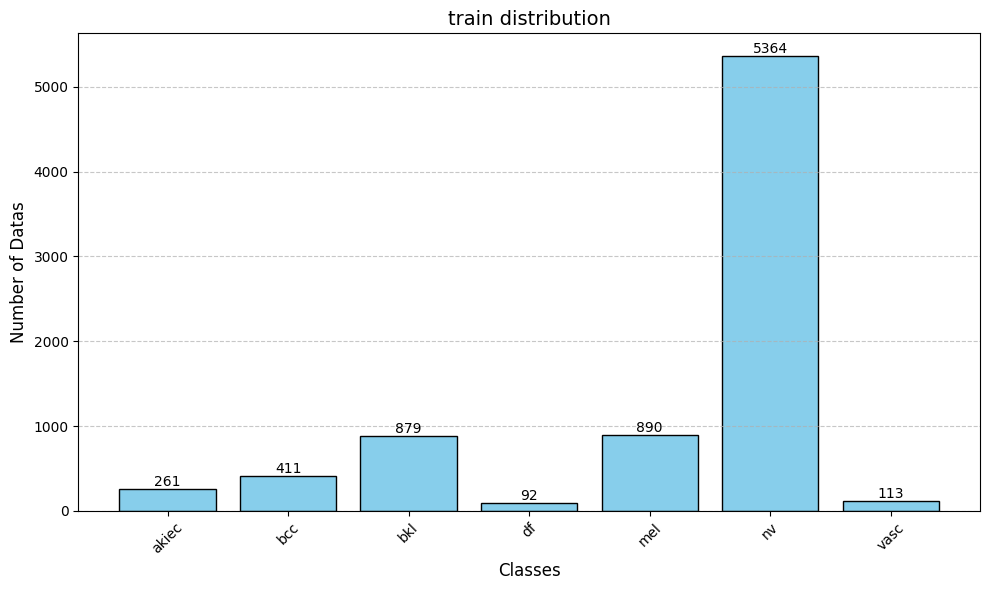

In [9]:
plot_distribution('train')

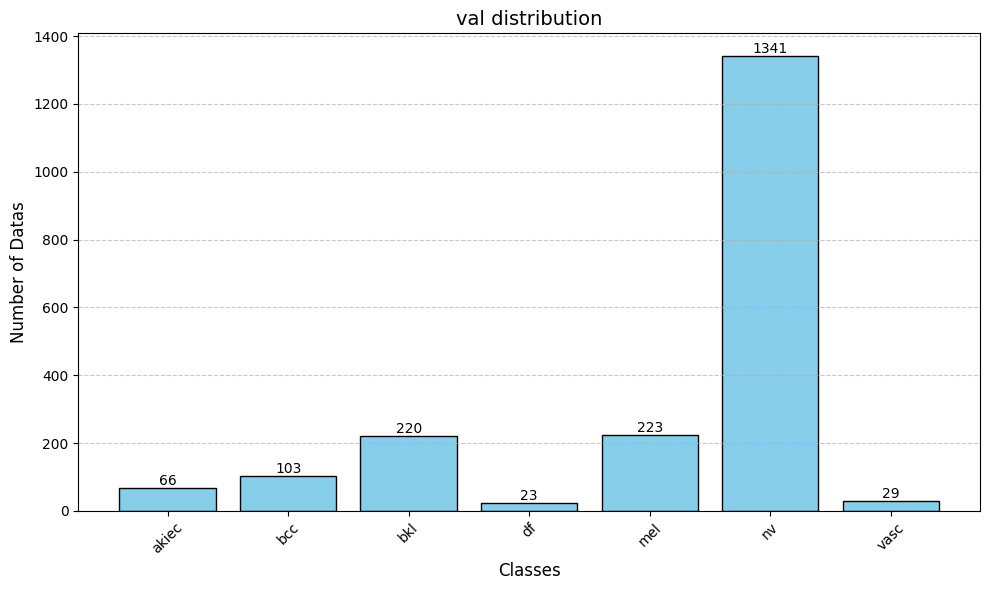

In [10]:
plot_distribution('val')

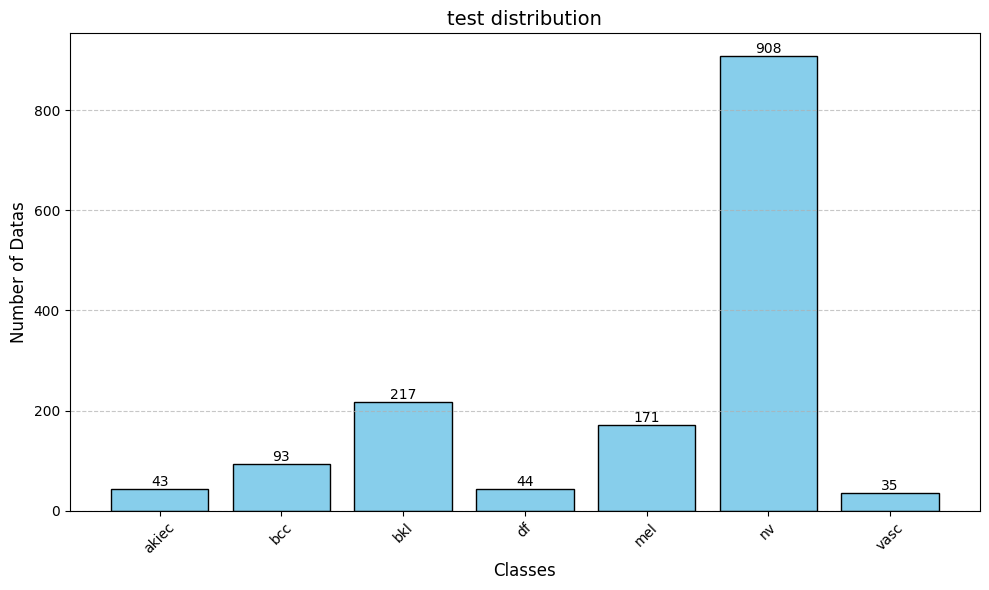

In [11]:
plot_distribution('test')

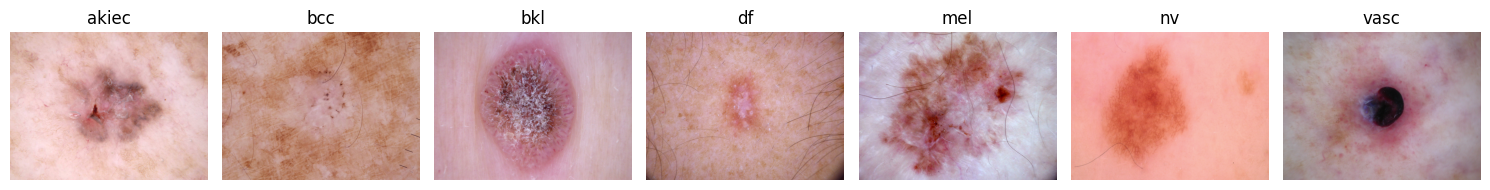

In [12]:
def load_one_image_per_class(root_dir):
    train_path = os.path.join(root_dir, 'train')
    images_per_class = {}
    
    if os.path.exists(train_path):
        for dirpath, dirnames, filenames in os.walk(train_path):
            for dirname in dirnames:
                subfolder_path = os.path.join(dirpath, dirname)
                # Get all image files in the subfolder
                image_files = [f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]
                if image_files:
                    # Randomly select one image
                    selected_image = random.choice(image_files)
                    images_per_class[dirname] = os.path.join(subfolder_path, selected_image)
                    
    return images_per_class

images_per_class = load_one_image_per_class(root_dir)

# Display the images in one line
plt.figure(figsize=(15, 5))  # Set the figure size
for i, (label, image_path) in enumerate(images_per_class.items()):
    img = mpimg.imread(image_path)  # Load the image
    plt.subplot(1, len(images_per_class), i + 1)  # Create a subplot for each image in one row
    plt.imshow(img)  # Display the image
    plt.title(label)  # Set the title as the class label
    plt.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()


In [13]:
class_names = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
n_classes = len(class_names)
print(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [14]:
# Create capsule network.
n_channels = 3
conv_outputs = 128 #Feature_map
num_primary_units = 8
primary_unit_size = 16 * 6 * 6  # fixme get from conv2d
output_unit_size = 16
img_size = 299
mode='128'
network = FixCapsNet(conv_inputs=n_channels,
                     conv_outputs=conv_outputs,
                     primary_units=num_primary_units,
                     primary_unit_size=primary_unit_size,
                     num_classes=n_classes,
                     output_unit_size=16,
                     init_weights=True,
                     mode=mode)
network = network.to(device)
summary(network,(n_channels,img_size,img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 141, 141]         124,544
              ReLU-2        [-1, 128, 141, 141]               0
FractionalMaxPool2d-3          [-1, 128, 20, 20]               0
            Conv2d-4          [-1, 128, 20, 20]          16,384
       BatchNorm2d-5          [-1, 128, 20, 20]             256
         Hardswish-6          [-1, 128, 20, 20]               0
 AdaptiveAvgPool2d-7            [-1, 128, 1, 1]               0
            Conv2d-8            [-1, 128, 1, 1]          16,384
              ReLU-9            [-1, 128, 1, 1]               0
           Conv2d-10            [-1, 128, 1, 1]          16,384
AdaptiveMaxPool2d-11            [-1, 128, 1, 1]               0
           Conv2d-12            [-1, 128, 1, 1]          16,384
             ReLU-13            [-1, 128, 1, 1]               0
           Conv2d-14            [-1, 1

In [ ]:
# dsize = (1, 3, 299, 299)
# input_data = torch.randn(dsize).to(device)
# pff(m_name="FixCaps"+'-'+mode,model=network,inputes=input_data)

In [16]:
def train(epoch):
    network.train()
    global best_train,train_evl_result#,evl_tmp_result
    running_loss,r_pre = 0., 0.
    print_step = len(train_loader)//2
    steps_num = len(train_loader)
    tmp_size = BatchSize
    print(f'\033[1;32m[Train Epoch:[{epoch}]{img_title} ==> Training]\033[0m ...')
    optimizer.zero_grad()
    train_tmp_result = torch.zeros(n_classes,n_classes)
    
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):        

        batch_idx += 1
        target_indices = target
        target_one_hot = one_hot(target, length=n_classes)
        data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

        output = network(data)
        loss = network.loss(output, target, size_average=True)       
        loss.backward()     
        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        
        v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True)) 
        pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
        r_pre += pred.eq(target_indices.view_as(pred)).squeeze().sum()
        tmp_pre = r_pre/(batch_idx*BatchSize)
        
        if batch_idx % print_step == 0 and batch_idx != steps_num:
            print("[{}/{}] Loss{:.5f},ACC:{:.5f}".format(batch_idx,len(train_loader),
                                                         loss,tmp_pre))
        if batch_idx % steps_num == 0 and train_num % tmp_size != 0:
            tmp_size = train_num % tmp_size
                          
        for i in range(tmp_size):
            pred_x = pred.numpy()
            train_tmp_result[target_indices[i]][pred_x[i]] +=1

        if best_train < tmp_pre and tmp_pre >= 80: 
            torch.save(network.state_dict(), iter_path)
        
    epoch_acc = r_pre / train_num
    epoch_loss = running_loss / len(train_loader)  
    train_loss_list.append(epoch_loss)
    train_acc_list.append(epoch_acc) 
    scheduler.step()
    if best_train < epoch_acc:
        best_train = epoch_acc
        train_evl_result = train_tmp_result.clone()
        torch.save(network.state_dict(), last_path)
        torch.save(train_evl_result, f'./tmp/{img_title}/{suf}/train_evl_result.pth')
    
    print("Train Epoch:[{}] Loss:{:.5f},Acc:{:.5f},Best_train:{:.5f}".format(epoch,epoch_loss,
                                                                     epoch_acc,best_train))

In [17]:
def test(split="test"):
    network.eval()
    global test_acc,eval_acc,best_acc,net_parameters
    global test_evl_result,val_evl_result#,evl_tmp_result
    cor_loss,correct,Auc, Acc= 0, 0, 0, 0
    evl_tmp_result = torch.zeros(n_classes,n_classes)
    
    if split == 'val':
        data_loader = val_loader
        tmp_size = V_size
        data_num = val_num
    else:
        data_loader = test_loader
        tmp_size = T_size
        data_num = test_num
        
    steps_num = len(data_loader)
    print(f'\033[35m{img_title} ==> {split} ...\033[0m')
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(data_loader)):
            batch_idx +=1
            target_indices = target#torch.Size([batch, 7])  
            target_one_hot = one_hot(target, length=n_classes)            
            data, target = Variable(data).to(device), Variable(target_one_hot).to(device)

            output= network(data)#torch.Size([batch_size, 7, 16, 1])         
            v_mag = torch.sqrt(torch.sum(output**2, dim=2, keepdim=True))
            pred = v_mag.data.max(1, keepdim=True)[1].cpu()#[9, 2, 1, 1, 6,..., 1, 4, 6, 5, 7,]
            
            if batch_idx % steps_num == 0 and data_num % tmp_size != 0:
                tmp_size = data_num % tmp_size
                          
            for i in range(tmp_size):
                pred_y = pred.numpy()
                evl_tmp_result[target_indices[i]][pred_y[i]] +=1 

        diag_sum = torch.sum(evl_tmp_result.diagonal())
        all_sum = torch.sum(evl_tmp_result) 
        test_acc = 100. * float(torch.div(diag_sum,all_sum)) 
        print(f"{split}_Acc:\033[1;32m{round(float(test_acc),3)}%\033[0m")

        if split == 'val':
            val_acc_list.append(test_acc)
            if test_acc >= best_acc:
                best_acc = test_acc
                val_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), save_PATH)
                torch.save(val_evl_result, f'./tmp/{img_title}/{suf}/best_evl_result.pth')
            print(f"Best_val:\033[1;32m[{round(float(best_acc),3)}%]\033[0m")
        else:
            test_acc_list.append(test_acc)
            if test_acc >= eval_acc:
                eval_acc = test_acc
                test_evl_result = evl_tmp_result.clone()#copy.deepcopy(input)
                torch.save(network.state_dict(), f'./tmp/{img_title}/{suf}/{split}_best_{img_title}_{suf}.pth')
                torch.save(test_evl_result, f'./tmp/{img_title}/{suf}/{split}_evl_result.pth')
            print(f"Best_eval:\033[1;32m[{round(float(eval_acc),3)}%]\033[0m")
    

In [20]:
try:
    print(f"suf: {suf}")
except NameError:
    suf = time.strftime("%m%d_%H%M%S", time.localtime())
    print(f"suf: {suf}")

# Define the path for the temporary storage
store_path = f'./tmp/{img_title}/{suf}'

# Create the directory if it does not exist
if not os.path.exists(store_path):
    os.makedirs(store_path)
    print(f'Store: "{store_path}" created')
else:
    print(f'Store: "{store_path}" already exists')

# Define paths for training and model files
iter_path = f'{store_path}/train_{img_title}_{suf}.pth'
save_PATH = f'{store_path}/best_{img_title}_{suf}.pth'
last_path = f'{store_path}/last_{img_title}_{suf}.pth'

# Print the save paths
print(f'Save path for best model: {save_PATH}')
print(f'Save path for last model: {last_path}')
print(f'Iteration path: {iter_path}')

suf: 1010_213534
Store: "./tmp/HAM10000/1010_213534" created
Save path for best model: ./tmp/HAM10000/1010_213534/best_HAM10000_1010_213534.pth
Save path for last model: ./tmp/HAM10000/1010_213534/last_HAM10000_1010_213534.pth
Iteration path: ./tmp/HAM10000/1010_213534/train_HAM10000_1010_213534.pth


In [18]:
learning_rate = 0.123
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)

In [21]:
num_epochs = 120
for epoch in range(1, num_epochs + 1): #4h 26m 46s
    train(epoch)
    test('val')

print('Finished Training')

[Train Epoch:[1]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:12<04:06, 10.28s/it]

[24/48] Loss0.21000,ACC:0.65799


100%|██████████| 48/48 [08:19<00:00, 10.41s/it]


Train Epoch:[1] Loss:0.23087,Acc:0.67416,Best_train:0.67416
HAM10000 ==> val ...


100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


val_Acc:67.132%
Best_val:[67.132%]
[Train Epoch:[2]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:44<04:15, 10.64s/it]

[24/48] Loss0.19920,ACC:0.67386


100%|██████████| 48/48 [08:56<00:00, 11.18s/it]


Train Epoch:[2] Loss:0.22207,Acc:0.67753,Best_train:0.67753
HAM10000 ==> val ...


100%|██████████| 51/51 [01:07<00:00,  1.32s/it]


val_Acc:70.474%
Best_val:[70.474%]
[Train Epoch:[3]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:45<04:24, 11.01s/it]

[24/48] Loss0.22813,ACC:0.67907


100%|██████████| 48/48 [08:55<00:00, 11.16s/it]


Train Epoch:[3] Loss:0.21813,Acc:0.68040,Best_train:0.68040
HAM10000 ==> val ...


100%|██████████| 51/51 [01:07<00:00,  1.33s/it]


val_Acc:69.726%
Best_val:[70.474%]
[Train Epoch:[4]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:31<04:14, 10.60s/it]

[24/48] Loss0.24650,ACC:0.67981


100%|██████████| 48/48 [08:39<00:00, 10.82s/it]


Train Epoch:[4] Loss:0.21581,Acc:0.68315,Best_train:0.68315
HAM10000 ==> val ...


100%|██████████| 51/51 [01:07<00:00,  1.32s/it]


val_Acc:70.923%
Best_val:[70.923%]
[Train Epoch:[5]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:33<04:08, 10.34s/it]

[24/48] Loss0.19841,ACC:0.68948


100%|██████████| 48/48 [08:38<00:00, 10.80s/it]


Train Epoch:[5] Loss:0.21388,Acc:0.68040,Best_train:0.68315
HAM10000 ==> val ...


100%|██████████| 51/51 [01:08<00:00,  1.34s/it]


val_Acc:70.823%
Best_val:[70.923%]
[Train Epoch:[6]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:36<04:12, 10.53s/it]

[24/48] Loss0.20845,ACC:0.67560


100%|██████████| 48/48 [08:43<00:00, 10.90s/it]


Train Epoch:[6] Loss:0.21502,Acc:0.68215,Best_train:0.68315
HAM10000 ==> val ...


100%|██████████| 51/51 [01:08<00:00,  1.34s/it]


val_Acc:71.022%
Best_val:[71.022%]
[Train Epoch:[7]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:35<04:10, 10.45s/it]

[24/48] Loss0.19562,ACC:0.68824


100%|██████████| 48/48 [08:44<00:00, 10.92s/it]


Train Epoch:[7] Loss:0.21558,Acc:0.68315,Best_train:0.68315
HAM10000 ==> val ...


100%|██████████| 51/51 [01:09<00:00,  1.36s/it]


val_Acc:69.825%
Best_val:[71.022%]
[Train Epoch:[8]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:38<04:13, 10.55s/it]

[24/48] Loss0.19494,ACC:0.68899


100%|██████████| 48/48 [08:46<00:00, 10.96s/it]


Train Epoch:[8] Loss:0.21602,Acc:0.67965,Best_train:0.68315
HAM10000 ==> val ...


100%|██████████| 51/51 [01:07<00:00,  1.32s/it]


val_Acc:73.067%
Best_val:[73.067%]
[Train Epoch:[9]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:35<04:11, 10.47s/it]

[24/48] Loss0.21040,ACC:0.68130


100%|██████████| 48/48 [08:44<00:00, 10.92s/it]


Train Epoch:[9] Loss:0.21259,Acc:0.68539,Best_train:0.68539
HAM10000 ==> val ...


100%|██████████| 51/51 [01:08<00:00,  1.35s/it]


val_Acc:71.771%
Best_val:[73.067%]
[Train Epoch:[10]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:36<04:12, 10.51s/it]

[24/48] Loss0.25001,ACC:0.68775


100%|██████████| 48/48 [08:43<00:00, 10.90s/it]


Train Epoch:[10] Loss:0.21142,Acc:0.68901,Best_train:0.68901
HAM10000 ==> val ...


100%|██████████| 51/51 [01:08<00:00,  1.35s/it]


val_Acc:73.666%
Best_val:[73.666%]
[Train Epoch:[11]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:34<04:11, 10.47s/it]

[24/48] Loss0.20062,ACC:0.69891


100%|██████████| 48/48 [08:42<00:00, 10.88s/it]


Train Epoch:[11] Loss:0.20468,Acc:0.69600,Best_train:0.69600
HAM10000 ==> val ...


100%|██████████| 51/51 [01:07<00:00,  1.33s/it]


val_Acc:76.06%
Best_val:[76.06%]
[Train Epoch:[12]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:37<04:14, 10.62s/it]

[24/48] Loss0.21940,ACC:0.69891


100%|██████████| 48/48 [08:44<00:00, 10.93s/it]


Train Epoch:[12] Loss:0.19979,Acc:0.69988,Best_train:0.69988
HAM10000 ==> val ...


100%|██████████| 51/51 [01:07<00:00,  1.32s/it]


val_Acc:76.459%
Best_val:[76.459%]
[Train Epoch:[13]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:36<04:11, 10.48s/it]

[24/48] Loss0.17793,ACC:0.70362


100%|██████████| 48/48 [08:44<00:00, 10.93s/it]


Train Epoch:[13] Loss:0.19549,Acc:0.70449,Best_train:0.70449
HAM10000 ==> val ...


100%|██████████| 51/51 [01:08<00:00,  1.35s/it]


val_Acc:78.853%
Best_val:[78.853%]
[Train Epoch:[14]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:37<04:12, 10.50s/it]

[24/48] Loss0.17133,ACC:0.70660


100%|██████████| 48/48 [08:42<00:00, 10.88s/it]


Train Epoch:[14] Loss:0.19146,Acc:0.71149,Best_train:0.71149
HAM10000 ==> val ...


100%|██████████| 51/51 [01:08<00:00,  1.34s/it]


val_Acc:79.202%
Best_val:[79.202%]
[Train Epoch:[15]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:37<04:14, 10.61s/it]

[24/48] Loss0.20672,ACC:0.71007


100%|██████████| 48/48 [08:47<00:00, 10.98s/it]


Train Epoch:[15] Loss:0.19064,Acc:0.71174,Best_train:0.71174
HAM10000 ==> val ...


100%|██████████| 51/51 [01:08<00:00,  1.34s/it]


val_Acc:78.853%
Best_val:[79.202%]
[Train Epoch:[16]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:37<04:11, 10.50s/it]

[24/48] Loss0.20809,ACC:0.70164


100%|██████████| 48/48 [08:42<00:00, 10.89s/it]


Train Epoch:[16] Loss:0.19113,Acc:0.70986,Best_train:0.71174
HAM10000 ==> val ...


100%|██████████| 51/51 [01:07<00:00,  1.33s/it]


val_Acc:79.8%
Best_val:[79.8%]
[Train Epoch:[17]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:35<04:10, 10.44s/it]

[24/48] Loss0.20043,ACC:0.70809


100%|██████████| 48/48 [08:48<00:00, 11.02s/it]


Train Epoch:[17] Loss:0.19287,Acc:0.71036,Best_train:0.71174
HAM10000 ==> val ...


100%|██████████| 51/51 [01:07<00:00,  1.32s/it]


val_Acc:79.002%
Best_val:[79.8%]
[Train Epoch:[18]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:49<04:13, 10.55s/it]

[24/48] Loss0.17065,ACC:0.71329


100%|██████████| 48/48 [08:55<00:00, 11.16s/it]


Train Epoch:[18] Loss:0.19506,Acc:0.70949,Best_train:0.71174
HAM10000 ==> val ...


100%|██████████| 51/51 [01:08<00:00,  1.34s/it]


val_Acc:79.701%
Best_val:[79.8%]
[Train Epoch:[19]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:36<04:13, 10.55s/it]

[24/48] Loss0.20651,ACC:0.70982


100%|██████████| 48/48 [08:51<00:00, 11.08s/it]


Train Epoch:[19] Loss:0.19408,Acc:0.71011,Best_train:0.71174
HAM10000 ==> val ...


100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


val_Acc:76.01%
Best_val:[79.8%]
[Train Epoch:[20]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [05:10<04:42, 11.75s/it]

[24/48] Loss0.16864,ACC:0.71205


100%|██████████| 48/48 [09:45<00:00, 12.19s/it]


Train Epoch:[20] Loss:0.19468,Acc:0.70874,Best_train:0.71174
HAM10000 ==> val ...


100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


val_Acc:77.656%
Best_val:[79.8%]
[Train Epoch:[21]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [05:07<04:35, 11.49s/it]

[24/48] Loss0.19273,ACC:0.71627


100%|██████████| 48/48 [09:39<00:00, 12.08s/it]


Train Epoch:[21] Loss:0.18957,Acc:0.72072,Best_train:0.72072
HAM10000 ==> val ...


100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


val_Acc:80.0%
Best_val:[80.0%]
[Train Epoch:[22]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [05:03<04:37, 11.57s/it]

[24/48] Loss0.17860,ACC:0.71701


100%|██████████| 48/48 [09:34<00:00, 11.96s/it]


Train Epoch:[22] Loss:0.18966,Acc:0.71598,Best_train:0.72072
HAM10000 ==> val ...


100%|██████████| 51/51 [01:15<00:00,  1.48s/it]


val_Acc:78.204%
Best_val:[80.0%]
[Train Epoch:[23]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [05:08<04:36, 11.50s/it]

[24/48] Loss0.22347,ACC:0.71925


100%|██████████| 48/48 [09:37<00:00, 12.03s/it]


Train Epoch:[23] Loss:0.18487,Acc:0.72222,Best_train:0.72222
HAM10000 ==> val ...


100%|██████████| 51/51 [01:14<00:00,  1.46s/it]


val_Acc:77.406%
Best_val:[80.0%]
[Train Epoch:[24]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [05:02<04:34, 11.45s/it]

[24/48] Loss0.17488,ACC:0.72197


100%|██████████| 48/48 [09:29<00:00, 11.87s/it]


Train Epoch:[24] Loss:0.18174,Acc:0.72747,Best_train:0.72747
HAM10000 ==> val ...


100%|██████████| 51/51 [01:13<00:00,  1.44s/it]


val_Acc:78.304%
Best_val:[80.0%]
[Train Epoch:[25]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [05:05<04:32, 11.36s/it]

[24/48] Loss0.19206,ACC:0.73462


100%|██████████| 48/48 [09:24<00:00, 11.77s/it]


Train Epoch:[25] Loss:0.18064,Acc:0.73159,Best_train:0.73159
HAM10000 ==> val ...


100%|██████████| 51/51 [01:08<00:00,  1.33s/it]


val_Acc:78.404%
Best_val:[80.0%]
[Train Epoch:[26]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:35<04:12, 10.54s/it]

[24/48] Loss0.20327,ACC:0.72991


100%|██████████| 48/48 [08:41<00:00, 10.87s/it]


Train Epoch:[26] Loss:0.18001,Acc:0.72784,Best_train:0.73159
HAM10000 ==> val ...


100%|██████████| 51/51 [01:07<00:00,  1.32s/it]


val_Acc:78.803%
Best_val:[80.0%]
[Train Epoch:[27]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:34<04:08, 10.36s/it]

[24/48] Loss0.15103,ACC:0.72817


100%|██████████| 48/48 [08:38<00:00, 10.81s/it]


Train Epoch:[27] Loss:0.18315,Acc:0.73021,Best_train:0.73159
HAM10000 ==> val ...


100%|██████████| 51/51 [01:07<00:00,  1.32s/it]


val_Acc:80.599%
Best_val:[80.599%]
[Train Epoch:[28]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:33<04:10, 10.42s/it]

[24/48] Loss0.20812,ACC:0.72966


100%|██████████| 48/48 [08:39<00:00, 10.83s/it]


Train Epoch:[28] Loss:0.18447,Acc:0.72172,Best_train:0.73159
HAM10000 ==> val ...


100%|██████████| 51/51 [01:07<00:00,  1.32s/it]


val_Acc:78.753%
Best_val:[80.599%]
[Train Epoch:[29]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:34<04:10, 10.43s/it]

[24/48] Loss0.18221,ACC:0.72197


100%|██████████| 48/48 [08:38<00:00, 10.81s/it]


Train Epoch:[29] Loss:0.18631,Acc:0.72509,Best_train:0.73159
HAM10000 ==> val ...


100%|██████████| 51/51 [01:06<00:00,  1.31s/it]


val_Acc:78.603%
Best_val:[80.599%]
[Train Epoch:[30]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:32<04:09, 10.42s/it]

[24/48] Loss0.18257,ACC:0.71156


100%|██████████| 48/48 [08:36<00:00, 10.77s/it]


Train Epoch:[30] Loss:0.19242,Acc:0.71536,Best_train:0.73159
HAM10000 ==> val ...


100%|██████████| 51/51 [01:07<00:00,  1.33s/it]


val_Acc:77.756%
Best_val:[80.599%]
[Train Epoch:[31]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:33<04:11, 10.47s/it]

[24/48] Loss0.17977,ACC:0.72569


100%|██████████| 48/48 [08:38<00:00, 10.80s/it]


Train Epoch:[31] Loss:0.18358,Acc:0.72921,Best_train:0.73159
HAM10000 ==> val ...


100%|██████████| 51/51 [01:10<00:00,  1.38s/it]


val_Acc:78.753%
Best_val:[80.599%]
[Train Epoch:[32]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:02<03:39,  9.16s/it]

[24/48] Loss0.17123,ACC:0.73487


100%|██████████| 48/48 [07:37<00:00,  9.54s/it]


Train Epoch:[32] Loss:0.18139,Acc:0.73159,Best_train:0.73159
HAM10000 ==> val ...


100%|██████████| 51/51 [00:58<00:00,  1.16s/it]


val_Acc:78.903%
Best_val:[80.599%]
[Train Epoch:[33]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:51<03:22,  8.43s/it]

[24/48] Loss0.17452,ACC:0.73313


100%|██████████| 48/48 [07:10<00:00,  8.97s/it]


Train Epoch:[33] Loss:0.17721,Acc:0.73633,Best_train:0.73633
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:82.244%
Best_val:[82.244%]
[Train Epoch:[34]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:41<03:20,  8.37s/it]

[24/48] Loss0.15943,ACC:0.73438


100%|██████████| 48/48 [07:00<00:00,  8.76s/it]


Train Epoch:[34] Loss:0.17631,Acc:0.73620,Best_train:0.73633
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:80.998%
Best_val:[82.244%]
[Train Epoch:[35]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:23,  8.48s/it]

[24/48] Loss0.16385,ACC:0.74975


100%|██████████| 48/48 [07:04<00:00,  8.85s/it]


Train Epoch:[35] Loss:0.17434,Acc:0.74332,Best_train:0.74332
HAM10000 ==> val ...


100%|██████████| 51/51 [00:55<00:00,  1.09s/it]


val_Acc:81.297%
Best_val:[82.244%]
[Train Epoch:[36]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:26,  8.59s/it]

[24/48] Loss0.17068,ACC:0.73562


100%|██████████| 48/48 [07:03<00:00,  8.82s/it]


Train Epoch:[36] Loss:0.17533,Acc:0.73908,Best_train:0.74332
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:81.546%
Best_val:[82.244%]
[Train Epoch:[37]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:21,  8.41s/it]

[24/48] Loss0.15955,ACC:0.73661


100%|██████████| 48/48 [07:02<00:00,  8.80s/it]


Train Epoch:[37] Loss:0.17936,Acc:0.73159,Best_train:0.74332
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


val_Acc:81.247%
Best_val:[82.244%]
[Train Epoch:[38]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:24,  8.53s/it]

[24/48] Loss0.17474,ACC:0.73338


100%|██████████| 48/48 [07:03<00:00,  8.82s/it]


Train Epoch:[38] Loss:0.18057,Acc:0.73021,Best_train:0.74332
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.12s/it]


val_Acc:80.299%
Best_val:[82.244%]
[Train Epoch:[39]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:23,  8.50s/it]

[24/48] Loss0.21590,ACC:0.74330


100%|██████████| 48/48 [07:04<00:00,  8.84s/it]


Train Epoch:[39] Loss:0.18207,Acc:0.73333,Best_train:0.74332
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.10s/it]


val_Acc:80.249%
Best_val:[82.244%]
[Train Epoch:[40]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:24,  8.51s/it]

[24/48] Loss0.17673,ACC:0.72842


100%|██████████| 48/48 [07:03<00:00,  8.82s/it]


Train Epoch:[40] Loss:0.18018,Acc:0.73283,Best_train:0.74332
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


val_Acc:81.446%
Best_val:[82.244%]
[Train Epoch:[41]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:22,  8.42s/it]

[24/48] Loss0.19453,ACC:0.73189


100%|██████████| 48/48 [07:03<00:00,  8.81s/it]


Train Epoch:[41] Loss:0.18013,Acc:0.73246,Best_train:0.74332
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:80.449%
Best_val:[82.244%]
[Train Epoch:[42]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:42<03:21,  8.41s/it]

[24/48] Loss0.16679,ACC:0.73834


100%|██████████| 48/48 [07:03<00:00,  8.83s/it]


Train Epoch:[42] Loss:0.17748,Acc:0.73620,Best_train:0.74332
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.12s/it]


val_Acc:80.449%
Best_val:[82.244%]
[Train Epoch:[43]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:23,  8.48s/it]

[24/48] Loss0.18608,ACC:0.74430


100%|██████████| 48/48 [07:03<00:00,  8.83s/it]


Train Epoch:[43] Loss:0.17514,Acc:0.73895,Best_train:0.74332
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.10s/it]


val_Acc:81.746%
Best_val:[82.244%]
[Train Epoch:[44]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:24,  8.51s/it]

[24/48] Loss0.17357,ACC:0.74405


100%|██████████| 48/48 [07:04<00:00,  8.85s/it]


Train Epoch:[44] Loss:0.17262,Acc:0.73770,Best_train:0.74332
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.12s/it]


val_Acc:82.793%
Best_val:[82.793%]
[Train Epoch:[45]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:24,  8.52s/it]

[24/48] Loss0.15478,ACC:0.75248


100%|██████████| 48/48 [07:05<00:00,  8.86s/it]


Train Epoch:[45] Loss:0.17117,Acc:0.74457,Best_train:0.74457
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:82.095%
Best_val:[82.793%]
[Train Epoch:[46]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:23,  8.46s/it]

[24/48] Loss0.15541,ACC:0.73537


100%|██████████| 48/48 [07:10<00:00,  8.96s/it]


Train Epoch:[46] Loss:0.17366,Acc:0.73596,Best_train:0.74457
HAM10000 ==> val ...


100%|██████████| 51/51 [01:02<00:00,  1.23s/it]


val_Acc:81.995%
Best_val:[82.793%]
[Train Epoch:[47]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:17<03:38,  9.12s/it]

[24/48] Loss0.17387,ACC:0.73735


100%|██████████| 48/48 [07:35<00:00,  9.50s/it]


Train Epoch:[47] Loss:0.17407,Acc:0.73970,Best_train:0.74457
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:82.394%
Best_val:[82.793%]
[Train Epoch:[48]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:25,  8.57s/it]

[24/48] Loss0.18288,ACC:0.73810


100%|██████████| 48/48 [07:03<00:00,  8.83s/it]


Train Epoch:[48] Loss:0.17665,Acc:0.73708,Best_train:0.74457
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.12s/it]


val_Acc:80.748%
Best_val:[82.793%]
[Train Epoch:[49]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:22,  8.46s/it]

[24/48] Loss0.16299,ACC:0.72842


100%|██████████| 48/48 [07:03<00:00,  8.82s/it]


Train Epoch:[49] Loss:0.17819,Acc:0.73446,Best_train:0.74457
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.12s/it]


val_Acc:80.648%
Best_val:[82.793%]
[Train Epoch:[50]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:25,  8.55s/it]

[24/48] Loss0.16475,ACC:0.73214


100%|██████████| 48/48 [07:04<00:00,  8.84s/it]


Train Epoch:[50] Loss:0.18123,Acc:0.72734,Best_train:0.74457
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:78.853%
Best_val:[82.793%]
[Train Epoch:[51]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:23,  8.48s/it]

[24/48] Loss0.15967,ACC:0.72545


100%|██████████| 48/48 [07:03<00:00,  8.83s/it]


Train Epoch:[51] Loss:0.17957,Acc:0.73670,Best_train:0.74457
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.12s/it]


val_Acc:84.04%
Best_val:[84.04%]
[Train Epoch:[52]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:23,  8.48s/it]

[24/48] Loss0.16786,ACC:0.74529


100%|██████████| 48/48 [07:02<00:00,  8.80s/it]


Train Epoch:[52] Loss:0.17510,Acc:0.74282,Best_train:0.74457
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:83.042%
Best_val:[84.04%]
[Train Epoch:[53]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:42<03:22,  8.43s/it]

[24/48] Loss0.16372,ACC:0.74554


100%|██████████| 48/48 [07:03<00:00,  8.82s/it]


Train Epoch:[53] Loss:0.17448,Acc:0.74220,Best_train:0.74457
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:81.845%
Best_val:[84.04%]
[Train Epoch:[54]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:24,  8.50s/it]

[24/48] Loss0.18683,ACC:0.73710


100%|██████████| 48/48 [07:02<00:00,  8.80s/it]


Train Epoch:[54] Loss:0.17126,Acc:0.74232,Best_train:0.74457
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


val_Acc:81.796%
Best_val:[84.04%]
[Train Epoch:[55]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:24,  8.53s/it]

[24/48] Loss0.20066,ACC:0.73388


100%|██████████| 48/48 [07:04<00:00,  8.84s/it]


Train Epoch:[55] Loss:0.16966,Acc:0.74170,Best_train:0.74457
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


val_Acc:81.945%
Best_val:[84.04%]
[Train Epoch:[56]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:22,  8.43s/it]

[24/48] Loss0.15791,ACC:0.74603


100%|██████████| 48/48 [07:02<00:00,  8.81s/it]


Train Epoch:[56] Loss:0.16821,Acc:0.74981,Best_train:0.74981
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:82.544%
Best_val:[84.04%]
[Train Epoch:[57]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:25,  8.54s/it]

[24/48] Loss0.17426,ACC:0.73834


100%|██████████| 48/48 [07:05<00:00,  8.87s/it]


Train Epoch:[57] Loss:0.17166,Acc:0.74082,Best_train:0.74981
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.12s/it]


val_Acc:81.147%
Best_val:[84.04%]
[Train Epoch:[58]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:41<03:22,  8.43s/it]

[24/48] Loss0.19213,ACC:0.73760


100%|██████████| 48/48 [07:00<00:00,  8.75s/it]


Train Epoch:[58] Loss:0.17177,Acc:0.74195,Best_train:0.74981
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.12s/it]


val_Acc:82.893%
Best_val:[84.04%]
[Train Epoch:[59]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:22,  8.46s/it]

[24/48] Loss0.16269,ACC:0.74702


100%|██████████| 48/48 [07:03<00:00,  8.82s/it]


Train Epoch:[59] Loss:0.17388,Acc:0.74395,Best_train:0.74981
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:83.84%
Best_val:[84.04%]
[Train Epoch:[60]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:23,  8.50s/it]

[24/48] Loss0.18806,ACC:0.73710


100%|██████████| 48/48 [07:02<00:00,  8.81s/it]


Train Epoch:[60] Loss:0.17837,Acc:0.73833,Best_train:0.74981
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:78.404%
Best_val:[84.04%]
[Train Epoch:[61]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:42<03:24,  8.50s/it]

[24/48] Loss0.18039,ACC:0.74132


100%|██████████| 48/48 [07:03<00:00,  8.83s/it]


Train Epoch:[61] Loss:0.17457,Acc:0.73708,Best_train:0.74981
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:81.047%
Best_val:[84.04%]
[Train Epoch:[62]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:23,  8.47s/it]

[24/48] Loss0.15364,ACC:0.74603


100%|██████████| 48/48 [07:03<00:00,  8.83s/it]


Train Epoch:[62] Loss:0.17411,Acc:0.74257,Best_train:0.74981
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.12s/it]


val_Acc:82.195%
Best_val:[84.04%]
[Train Epoch:[63]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:23,  8.46s/it]

[24/48] Loss0.15698,ACC:0.74554


100%|██████████| 48/48 [07:04<00:00,  8.84s/it]


Train Epoch:[63] Loss:0.16865,Acc:0.74195,Best_train:0.74981
HAM10000 ==> val ...


100%|██████████| 51/51 [00:55<00:00,  1.10s/it]


val_Acc:83.392%
Best_val:[84.04%]
[Train Epoch:[64]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:42<03:22,  8.43s/it]

[24/48] Loss0.12312,ACC:0.75918


100%|██████████| 48/48 [07:00<00:00,  8.77s/it]


Train Epoch:[64] Loss:0.16658,Acc:0.75393,Best_train:0.75393
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


val_Acc:83.042%
Best_val:[84.04%]
[Train Epoch:[65]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:42<03:20,  8.36s/it]

[24/48] Loss0.14151,ACC:0.75422


100%|██████████| 48/48 [07:00<00:00,  8.75s/it]


Train Epoch:[65] Loss:0.16613,Acc:0.75218,Best_train:0.75393
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:82.893%
Best_val:[84.04%]
[Train Epoch:[66]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:23,  8.50s/it]

[24/48] Loss0.16306,ACC:0.74802


100%|██████████| 48/48 [07:03<00:00,  8.82s/it]


Train Epoch:[66] Loss:0.16577,Acc:0.75543,Best_train:0.75543
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.12s/it]


val_Acc:82.643%
Best_val:[84.04%]
[Train Epoch:[67]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:45<03:25,  8.57s/it]

[24/48] Loss0.18218,ACC:0.74876


100%|██████████| 48/48 [07:06<00:00,  8.88s/it]


Train Epoch:[67] Loss:0.16952,Acc:0.74607,Best_train:0.75543
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


val_Acc:84.19%
Best_val:[84.19%]
[Train Epoch:[68]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:42<03:23,  8.47s/it]

[24/48] Loss0.16800,ACC:0.75595


100%|██████████| 48/48 [07:00<00:00,  8.77s/it]


Train Epoch:[68] Loss:0.16978,Acc:0.74981,Best_train:0.75543
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:83.99%
Best_val:[84.19%]
[Train Epoch:[69]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:24,  8.51s/it]

[24/48] Loss0.18640,ACC:0.73214


100%|██████████| 48/48 [07:05<00:00,  8.86s/it]


Train Epoch:[69] Loss:0.17480,Acc:0.73970,Best_train:0.75543
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:81.247%
Best_val:[84.19%]
[Train Epoch:[70]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:23,  8.49s/it]

[24/48] Loss0.15314,ACC:0.75496


100%|██████████| 48/48 [07:05<00:00,  8.86s/it]


Train Epoch:[70] Loss:0.17429,Acc:0.74157,Best_train:0.75543
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.12s/it]


val_Acc:80.249%
Best_val:[84.19%]
[Train Epoch:[71]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:24,  8.50s/it]

[24/48] Loss0.16339,ACC:0.74058


100%|██████████| 48/48 [07:04<00:00,  8.84s/it]


Train Epoch:[71] Loss:0.17085,Acc:0.74045,Best_train:0.75543
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


val_Acc:80.698%
Best_val:[84.19%]
[Train Epoch:[72]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:42<03:22,  8.45s/it]

[24/48] Loss0.15683,ACC:0.75074


100%|██████████| 48/48 [07:01<00:00,  8.78s/it]


Train Epoch:[72] Loss:0.16954,Acc:0.74906,Best_train:0.75543
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:81.646%
Best_val:[84.19%]
[Train Epoch:[73]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:45<03:23,  8.48s/it]

[24/48] Loss0.15882,ACC:0.74752


100%|██████████| 48/48 [07:06<00:00,  8.89s/it]


Train Epoch:[73] Loss:0.16843,Acc:0.74682,Best_train:0.75543
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.12s/it]


val_Acc:82.943%
Best_val:[84.19%]
[Train Epoch:[74]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:23,  8.46s/it]

[24/48] Loss0.17211,ACC:0.75918


100%|██████████| 48/48 [07:03<00:00,  8.82s/it]


Train Epoch:[74] Loss:0.16437,Acc:0.75368,Best_train:0.75543
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:82.793%
Best_val:[84.19%]
[Train Epoch:[75]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:24,  8.51s/it]

[24/48] Loss0.16164,ACC:0.76314


100%|██████████| 48/48 [07:02<00:00,  8.81s/it]


Train Epoch:[75] Loss:0.16358,Acc:0.75431,Best_train:0.75543
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


val_Acc:83.392%
Best_val:[84.19%]
[Train Epoch:[76]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:23,  8.48s/it]

[24/48] Loss0.14319,ACC:0.75595


100%|██████████| 48/48 [07:05<00:00,  8.86s/it]


Train Epoch:[76] Loss:0.16313,Acc:0.75655,Best_train:0.75655
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


val_Acc:83.392%
Best_val:[84.19%]
[Train Epoch:[77]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:23,  8.48s/it]

[24/48] Loss0.13665,ACC:0.76190


100%|██████████| 48/48 [07:01<00:00,  8.79s/it]


Train Epoch:[77] Loss:0.16677,Acc:0.75206,Best_train:0.75655
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.12s/it]


val_Acc:82.893%
Best_val:[84.19%]
[Train Epoch:[78]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:24,  8.50s/it]

[24/48] Loss0.16472,ACC:0.75868


100%|██████████| 48/48 [07:03<00:00,  8.82s/it]


Train Epoch:[78] Loss:0.16873,Acc:0.74994,Best_train:0.75655
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


val_Acc:81.297%
Best_val:[84.19%]
[Train Epoch:[79]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:23,  8.46s/it]

[24/48] Loss0.18956,ACC:0.74653


100%|██████████| 48/48 [07:02<00:00,  8.80s/it]


Train Epoch:[79] Loss:0.17013,Acc:0.75094,Best_train:0.75655
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.12s/it]


val_Acc:82.244%
Best_val:[84.19%]
[Train Epoch:[80]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:24,  8.54s/it]

[24/48] Loss0.16170,ACC:0.74454


100%|██████████| 48/48 [07:02<00:00,  8.81s/it]


Train Epoch:[80] Loss:0.17294,Acc:0.73983,Best_train:0.75655
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:82.095%
Best_val:[84.19%]
[Train Epoch:[81]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:23,  8.49s/it]

[24/48] Loss0.17016,ACC:0.75074


100%|██████████| 48/48 [07:02<00:00,  8.81s/it]


Train Epoch:[81] Loss:0.17254,Acc:0.74270,Best_train:0.75655
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


val_Acc:82.394%
Best_val:[84.19%]
[Train Epoch:[82]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:24,  8.53s/it]

[24/48] Loss0.17176,ACC:0.75347


100%|██████████| 48/48 [07:05<00:00,  8.86s/it]


Train Epoch:[82] Loss:0.16731,Acc:0.75169,Best_train:0.75655
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


val_Acc:82.394%
Best_val:[84.19%]
[Train Epoch:[83]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:25,  8.55s/it]

[24/48] Loss0.14636,ACC:0.74975


100%|██████████| 48/48 [07:05<00:00,  8.87s/it]


Train Epoch:[83] Loss:0.16666,Acc:0.74819,Best_train:0.75655
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:81.596%
Best_val:[84.19%]
[Train Epoch:[84]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:22,  8.42s/it]

[24/48] Loss0.16875,ACC:0.75744


100%|██████████| 48/48 [07:02<00:00,  8.80s/it]


Train Epoch:[84] Loss:0.16325,Acc:0.75793,Best_train:0.75793
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


val_Acc:82.943%
Best_val:[84.19%]
[Train Epoch:[85]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:22,  8.44s/it]

[24/48] Loss0.16087,ACC:0.76488


100%|██████████| 48/48 [07:02<00:00,  8.80s/it]


Train Epoch:[85] Loss:0.16116,Acc:0.75805,Best_train:0.75805
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.12s/it]


val_Acc:82.843%
Best_val:[84.19%]
[Train Epoch:[86]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:45<03:23,  8.49s/it]

[24/48] Loss0.17649,ACC:0.75521


100%|██████████| 48/48 [07:05<00:00,  8.87s/it]


Train Epoch:[86] Loss:0.16157,Acc:0.75605,Best_train:0.75805
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:82.893%
Best_val:[84.19%]
[Train Epoch:[87]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:23,  8.49s/it]

[24/48] Loss0.17125,ACC:0.75818


100%|██████████| 48/48 [07:02<00:00,  8.81s/it]


Train Epoch:[87] Loss:0.16331,Acc:0.75668,Best_train:0.75805
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:83.99%
Best_val:[84.19%]
[Train Epoch:[88]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:25,  8.54s/it]

[24/48] Loss0.15464,ACC:0.75174


100%|██████████| 48/48 [07:04<00:00,  8.85s/it]


Train Epoch:[88] Loss:0.16636,Acc:0.74707,Best_train:0.75805
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.12s/it]


val_Acc:80.948%
Best_val:[84.19%]
[Train Epoch:[89]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:24,  8.50s/it]

[24/48] Loss0.15842,ACC:0.75000


100%|██████████| 48/48 [07:05<00:00,  8.86s/it]


Train Epoch:[89] Loss:0.16734,Acc:0.75243,Best_train:0.75805
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.12s/it]


val_Acc:82.743%
Best_val:[84.19%]
[Train Epoch:[90]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:25,  8.54s/it]

[24/48] Loss0.14008,ACC:0.75223


100%|██████████| 48/48 [07:05<00:00,  8.86s/it]


Train Epoch:[90] Loss:0.16874,Acc:0.75006,Best_train:0.75805
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.12s/it]


val_Acc:83.641%
Best_val:[84.19%]
[Train Epoch:[91]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:23,  8.50s/it]

[24/48] Loss0.12701,ACC:0.75099


100%|██████████| 48/48 [07:04<00:00,  8.84s/it]


Train Epoch:[91] Loss:0.16644,Acc:0.75206,Best_train:0.75805
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.12s/it]


val_Acc:83.99%
Best_val:[84.19%]
[Train Epoch:[92]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:22,  8.46s/it]

[24/48] Loss0.17401,ACC:0.75248


100%|██████████| 48/48 [07:04<00:00,  8.84s/it]


Train Epoch:[92] Loss:0.16600,Acc:0.75518,Best_train:0.75805
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:82.943%
Best_val:[84.19%]
[Train Epoch:[93]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:24,  8.51s/it]

[24/48] Loss0.15555,ACC:0.76389


100%|██████████| 48/48 [07:02<00:00,  8.81s/it]


Train Epoch:[93] Loss:0.16233,Acc:0.76155,Best_train:0.76155
HAM10000 ==> val ...


100%|██████████| 51/51 [01:01<00:00,  1.20s/it]


val_Acc:83.89%
Best_val:[84.19%]
[Train Epoch:[94]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:01<03:40,  9.18s/it]

[24/48] Loss0.16683,ACC:0.75372


100%|██████████| 48/48 [07:38<00:00,  9.54s/it]


Train Epoch:[94] Loss:0.15860,Acc:0.76467,Best_train:0.76467
HAM10000 ==> val ...


100%|██████████| 51/51 [00:59<00:00,  1.17s/it]


val_Acc:83.94%
Best_val:[84.19%]
[Train Epoch:[95]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:52<03:26,  8.59s/it]

[24/48] Loss0.15256,ACC:0.75471


100%|██████████| 48/48 [07:15<00:00,  9.06s/it]


Train Epoch:[95] Loss:0.15758,Acc:0.76255,Best_train:0.76467
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


val_Acc:83.99%
Best_val:[84.19%]
[Train Epoch:[96]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:23,  8.48s/it]

[24/48] Loss0.13859,ACC:0.77034


100%|██████████| 48/48 [07:05<00:00,  8.87s/it]


Train Epoch:[96] Loss:0.15909,Acc:0.76255,Best_train:0.76467
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.12s/it]


val_Acc:83.791%
Best_val:[84.19%]
[Train Epoch:[97]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:45<03:26,  8.58s/it]

[24/48] Loss0.11481,ACC:0.76513


100%|██████████| 48/48 [07:06<00:00,  8.88s/it]


Train Epoch:[97] Loss:0.16174,Acc:0.75930,Best_train:0.76467
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.14s/it]


val_Acc:82.843%
Best_val:[84.19%]
[Train Epoch:[98]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:45<03:25,  8.56s/it]

[24/48] Loss0.18918,ACC:0.75273


100%|██████████| 48/48 [07:07<00:00,  8.91s/it]


Train Epoch:[98] Loss:0.16438,Acc:0.75481,Best_train:0.76467
HAM10000 ==> val ...


100%|██████████| 51/51 [00:58<00:00,  1.14s/it]


val_Acc:83.192%
Best_val:[84.19%]
[Train Epoch:[99]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:47<03:24,  8.50s/it]

[24/48] Loss0.19126,ACC:0.74380


100%|██████████| 48/48 [06:55<00:00,  8.66s/it]


Train Epoch:[99] Loss:0.16754,Acc:0.75144,Best_train:0.76467
HAM10000 ==> val ...


100%|██████████| 51/51 [00:54<00:00,  1.07s/it]


val_Acc:81.895%
Best_val:[84.19%]
[Train Epoch:[100]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:29<03:09,  7.88s/it]

[24/48] Loss0.16081,ACC:0.75422


100%|██████████| 48/48 [06:40<00:00,  8.35s/it]


Train Epoch:[100] Loss:0.16779,Acc:0.74869,Best_train:0.76467
HAM10000 ==> val ...


100%|██████████| 51/51 [01:01<00:00,  1.20s/it]


val_Acc:83.84%
Best_val:[84.19%]
[Train Epoch:[101]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:05<03:43,  9.31s/it]

[24/48] Loss0.16082,ACC:0.75000


100%|██████████| 48/48 [07:44<00:00,  9.67s/it]


Train Epoch:[101] Loss:0.16659,Acc:0.75094,Best_train:0.76467
HAM10000 ==> val ...


100%|██████████| 51/51 [00:59<00:00,  1.17s/it]


val_Acc:82.494%
Best_val:[84.19%]
[Train Epoch:[102]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:51<03:29,  8.72s/it]

[24/48] Loss0.16869,ACC:0.75397


100%|██████████| 48/48 [07:15<00:00,  9.07s/it]


Train Epoch:[102] Loss:0.16299,Acc:0.75818,Best_train:0.76467
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


val_Acc:83.591%
Best_val:[84.19%]
[Train Epoch:[103]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:45<03:25,  8.58s/it]

[24/48] Loss0.16405,ACC:0.76835


100%|██████████| 48/48 [07:36<00:00,  9.52s/it]


Train Epoch:[103] Loss:0.16027,Acc:0.76067,Best_train:0.76467
HAM10000 ==> val ...


100%|██████████| 51/51 [01:03<00:00,  1.24s/it]


val_Acc:85.586%
Best_val:[85.586%]
[Train Epoch:[104]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:06<03:44,  9.36s/it]

[24/48] Loss0.16338,ACC:0.76166


100%|██████████| 48/48 [07:43<00:00,  9.66s/it]


Train Epoch:[104] Loss:0.15868,Acc:0.76517,Best_train:0.76517
HAM10000 ==> val ...


100%|██████████| 51/51 [00:58<00:00,  1.15s/it]


val_Acc:83.691%
Best_val:[85.586%]
[Train Epoch:[105]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:47<03:28,  8.69s/it]

[24/48] Loss0.16686,ACC:0.76116


100%|██████████| 48/48 [07:11<00:00,  8.99s/it]


Train Epoch:[105] Loss:0.15629,Acc:0.76529,Best_train:0.76529
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.13s/it]


val_Acc:83.491%
Best_val:[85.586%]
[Train Epoch:[106]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:31<03:13,  8.05s/it]

[24/48] Loss0.13849,ACC:0.76513


100%|██████████| 48/48 [06:55<00:00,  8.66s/it]


Train Epoch:[106] Loss:0.15748,Acc:0.76767,Best_train:0.76767
HAM10000 ==> val ...


100%|██████████| 51/51 [00:59<00:00,  1.16s/it]


val_Acc:84.289%
Best_val:[85.586%]
[Train Epoch:[107]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:43<03:13,  8.07s/it]

[24/48] Loss0.16676,ACC:0.76488


100%|██████████| 48/48 [06:47<00:00,  8.49s/it]


Train Epoch:[107] Loss:0.16091,Acc:0.76142,Best_train:0.76767
HAM10000 ==> val ...


100%|██████████| 51/51 [00:55<00:00,  1.08s/it]


val_Acc:84.738%
Best_val:[85.586%]
[Train Epoch:[108]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:28<03:09,  7.89s/it]

[24/48] Loss0.17464,ACC:0.75967


100%|██████████| 48/48 [06:53<00:00,  8.62s/it]


Train Epoch:[108] Loss:0.16086,Acc:0.76142,Best_train:0.76767
HAM10000 ==> val ...


100%|██████████| 51/51 [01:00<00:00,  1.19s/it]


val_Acc:82.993%
Best_val:[85.586%]
[Train Epoch:[109]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:29<03:09,  7.88s/it]

[24/48] Loss0.15511,ACC:0.74975


100%|██████████| 48/48 [06:34<00:00,  8.21s/it]


Train Epoch:[109] Loss:0.16408,Acc:0.75119,Best_train:0.76767
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:82.145%
Best_val:[85.586%]
[Train Epoch:[110]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:34<03:10,  7.94s/it]

[24/48] Loss0.18451,ACC:0.75918


100%|██████████| 48/48 [06:38<00:00,  8.31s/it]


Train Epoch:[110] Loss:0.16453,Acc:0.75655,Best_train:0.76767
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.11s/it]


val_Acc:82.793%
Best_val:[85.586%]
[Train Epoch:[111]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:37<03:12,  8.04s/it]

[24/48] Loss0.14670,ACC:0.75273


100%|██████████| 48/48 [06:59<00:00,  8.74s/it]


Train Epoch:[111] Loss:0.16543,Acc:0.75605,Best_train:0.76767
HAM10000 ==> val ...


100%|██████████| 51/51 [00:58<00:00,  1.14s/it]


val_Acc:82.244%
Best_val:[85.586%]
[Train Epoch:[112]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:52<03:31,  8.81s/it]

[24/48] Loss0.14443,ACC:0.75942


100%|██████████| 48/48 [07:20<00:00,  9.17s/it]


Train Epoch:[112] Loss:0.16171,Acc:0.76342,Best_train:0.76767
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.12s/it]


val_Acc:82.544%
Best_val:[85.586%]
[Train Epoch:[113]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:44<03:24,  8.50s/it]

[24/48] Loss0.17150,ACC:0.76935


100%|██████████| 48/48 [07:08<00:00,  8.92s/it]


Train Epoch:[113] Loss:0.15872,Acc:0.76629,Best_train:0.76767
HAM10000 ==> val ...


100%|██████████| 51/51 [00:53<00:00,  1.06s/it]


val_Acc:82.993%
Best_val:[85.586%]
[Train Epoch:[114]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:50<03:44,  9.37s/it]

[24/48] Loss0.19146,ACC:0.76612


100%|██████████| 48/48 [07:31<00:00,  9.41s/it]


Train Epoch:[114] Loss:0.15725,Acc:0.76442,Best_train:0.76767
HAM10000 ==> val ...


100%|██████████| 51/51 [01:02<00:00,  1.22s/it]


val_Acc:83.491%
Best_val:[85.586%]
[Train Epoch:[115]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:55<03:16,  8.17s/it]

[24/48] Loss0.15524,ACC:0.76687


100%|██████████| 48/48 [07:11<00:00,  9.00s/it]


Train Epoch:[115] Loss:0.15624,Acc:0.76529,Best_train:0.76767
HAM10000 ==> val ...


100%|██████████| 51/51 [00:56<00:00,  1.12s/it]


val_Acc:83.042%
Best_val:[85.586%]
[Train Epoch:[116]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:34<03:13,  8.08s/it]

[24/48] Loss0.16151,ACC:0.77331


100%|██████████| 48/48 [07:03<00:00,  8.83s/it]


Train Epoch:[116] Loss:0.15581,Acc:0.76754,Best_train:0.76767
HAM10000 ==> val ...


100%|██████████| 51/51 [00:57<00:00,  1.14s/it]


val_Acc:83.89%
Best_val:[85.586%]
[Train Epoch:[117]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [04:02<03:30,  8.77s/it]

[24/48] Loss0.16447,ACC:0.76860


100%|██████████| 48/48 [07:33<00:00,  9.45s/it]


Train Epoch:[117] Loss:0.15704,Acc:0.76517,Best_train:0.76767
HAM10000 ==> val ...


100%|██████████| 51/51 [01:00<00:00,  1.18s/it]


val_Acc:82.045%
Best_val:[85.586%]
[Train Epoch:[118]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:51<03:49,  9.57s/it]

[24/48] Loss0.15290,ACC:0.76364


100%|██████████| 48/48 [07:31<00:00,  9.41s/it]


Train Epoch:[118] Loss:0.16063,Acc:0.76230,Best_train:0.76767
HAM10000 ==> val ...


100%|██████████| 51/51 [00:58<00:00,  1.16s/it]


val_Acc:83.042%
Best_val:[85.586%]
[Train Epoch:[119]HAM10000 ==> Training] ...


 50%|█████     | 24/48 [03:47<03:18,  8.25s/it]

[24/48] Loss0.15725,ACC:0.75744


100%|██████████| 48/48 [07:15<00:00,  9.08s/it]


Train Epoch:[119] Loss:0.16452,Acc:0.75743,Best_train:0.76767
HAM10000 ==> val ...


100%|██████████| 51/51 [01:03<00:00,  1.24s/it]


val_Acc:83.392%
Best_val:[85.586%]
[Train Epoch:[120]HAM10000 ==> Training] ...


 12%|█▎        | 6/48 [01:30<10:36, 15.15s/it]


KeyboardInterrupt: 